In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from DBReader.DBReader import SyncReader

In [2]:
# Open the dataset
db = SyncReader('RADIal/RECORD@2020-11-22_12.28.47/',master='camera',tolerance=40000)

-------------------------------------------------------------------------
- Sensors available:
-     scala
-     radar_ch2
-     can
-     camera
-     radar_ch1
-     radar_ch3
-     radar_ch0
-     gps
-
- You might use function "setSensorFilters" to select sensors you want to read!
-------------------------------------------------------------------------
Total tolerance errors:  0.0 %


In [62]:
# Load the camera calibration parameters
calib = np.load('camera_calib.npy',allow_pickle=True).item()

In [63]:
# Retrieve one sample
data = db.GetSensorData(400)

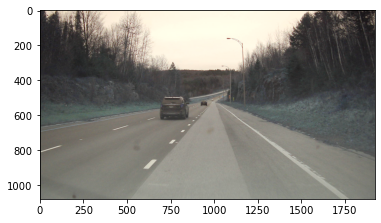

In [64]:
# Display the camera image
image = data['camera']['data']
plt.imshow(image)

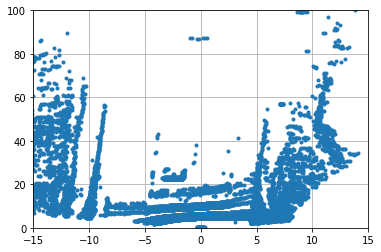

In [65]:
# Get the laser point cloud
pts = data['scala']['data']
plt.plot(-pts[:,1],pts[:,0],'.')
plt.xlim(-15,15)
plt.ylim(0,100)
plt.grid()

In [66]:
print('Number of points:',pts.shape[0])
print('Parameters per point:',pts.shape[1])

Number of points: 15062
Parameters per point: 11


In [67]:
# There are 11 parameters per point described sctructured as follow:
# [X, Y, Z, intensity, radialDistance, elevation_Angle, azimuth_angle, layer_index]

# Here is the trick, the Laser Scanner has 2 mirrors, one even and one odd. 
# There is a slight elevation angle difference between the 2 mirrors, so we have to compensate that angle

In [68]:
def ConpensateLayerAngle(pcl,index,sensor_height):
    
    offset=0
    if(index%2==0):
        offset = np.deg2rad(.6)

    x = pcl[:,4] * np.cos(pcl[:,5]+offset) * np.cos(pcl[:,6])
    y = pcl[:,4] * np.cos(pcl[:,5]+offset) * np.sin(pcl[:,6])
    z = pcl[:,4] * np.sin(pcl[:,5]+offset) + sensor_height
    
    pcl[:,0] = x
    pcl[:,1] = y
    pcl[:,2] = z
    
    return pcl

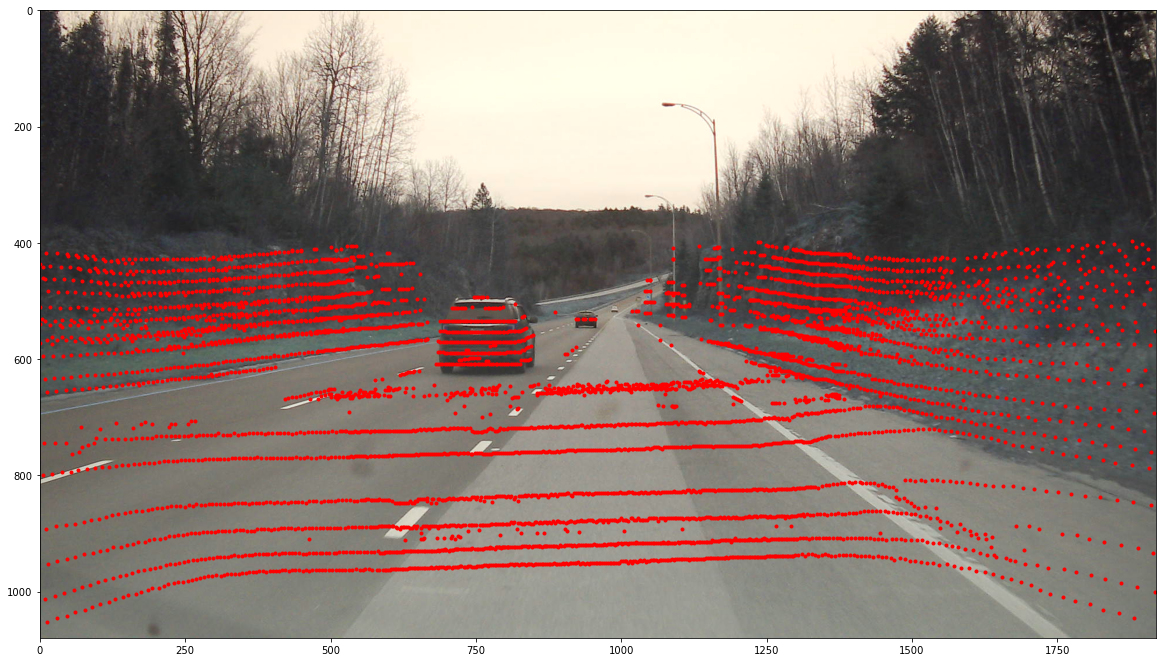

In [69]:
# Now, we can project 3D points into the camera space

pts = ConpensateLayerAngle(pts,data['scala']['sample_number'],0.42)[:,:3]
pts[:,[0, 1, 2]] = pts[:,[1, 0,2]] # Swap the order
pts[:,0]*=-1 # Left is positive

imgpts, _ = cv2.projectPoints(np.array(pts), 
                              calib['extrinsic']['rotation_vector'], 
                              calib['extrinsic']['translation_vector'],
                              calib['intrinsic']['camera_matrix'],
                              calib['intrinsic']['distortion_coefficients'])

imgpts=imgpts.squeeze(1).astype('int')

# Keep only points inside the image size
idx = np.where( (imgpts[:,0]>=0) & (imgpts[:,0]<image.shape[1]) & (imgpts[:,1]>=0) & (imgpts[:,1]<image.shape[0]))[0]

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.plot(imgpts[idx,0],imgpts[idx,1],'r.')